In [58]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import glob

import IPython.display as ipd

import explore


import librosa
import librosa.display
import matplotlib.pyplot as plt
import sed_utils


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
root_path = '/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_8000Hz/Training_Set/'
csv_paths = glob.glob(os.path.join(root_path, '*/*.csv'))
wav_paths = [x.replace('csv', 'wav') for x in csv_paths]

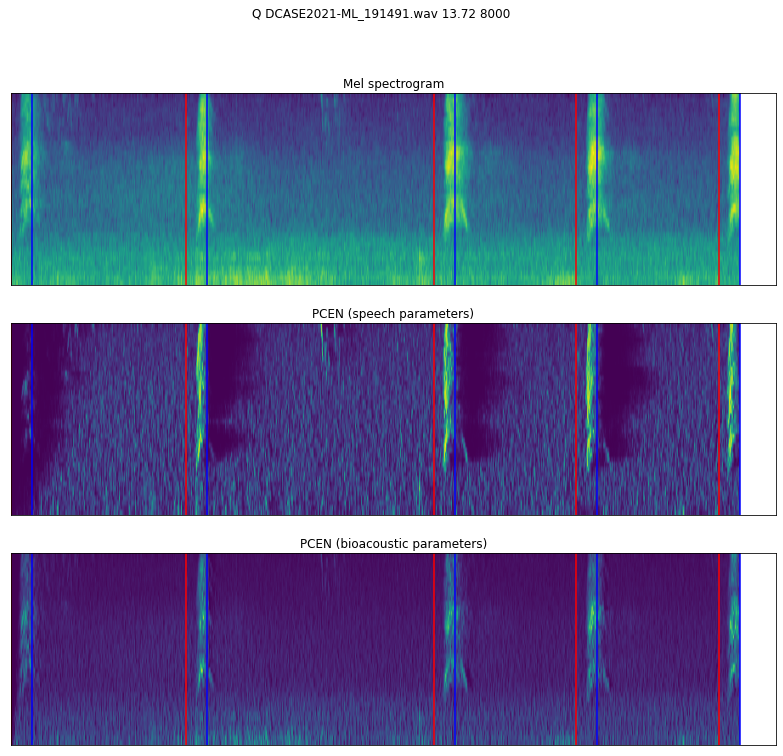

In [61]:
# for csv_path, wav_path in list(zip(csv_paths, wav_paths)):
#     #print('#############################################')
#     #print(wav_path)
#     #print('#############################################')
    
csv_path = '/mnt/storage_1/datasets/bioacoustics_dcase2022/Development_Set_8000Hz/Validation_Set/ML/DCASE2021-ML_191491.csv'
wav_path = csv_path.replace('.csv', '.wav')

annotation_df = pd.read_csv(csv_path)
event_classes = annotation_df.columns[3:]
event_category = 'POS'
n_events = 5 #5

for event_class in event_classes:
    events_df = annotation_df[annotation_df[event_class] == event_category]
    if len(events_df) > n_events:

        audio_segment, times, sample_rate = explore.get_first_audio_events_consecutive_audio(wav_path, annotation_df, event_class=event_class, event_category='POS', n=n_events, expand=0.0)
        total_duration = len(audio_segment) / sample_rate
        if total_duration < 120:

            #print('---------------------------------------------')
            #print('--' ,event_class)
            #print('---------------------------------------------')

            #D = librosa.stft(audio_segment)  # STFT of y
#             D = librosa.feature.melspectrogram(audio_segment, sr=sample_rate)
#             S_db = librosa.power_to_db(np.abs(D), ref=np.max)
#             S_pcen_default = librosa.core.pcen(D, sr=sample_rate)
#             S_pcen_bioacoustic = librosa.core.pcen(
#                 D, 
#                 sr=sample_rate,
#                 gain=0.8,
#                 bias=10,
#                 power=0.25,
#                 time_constant=0.06,
#                 eps=1e-6
#             )

            bioacoustic_conf = sed_utils.get_bioacoustic_pcen_conf()
            speech_conf      = sed_utils.get_speech_pcen_conf()
            transform_mel      = lambda x: sed_utils.wav_to_mel(x - (np.sum(x)/np.size(x)), sample_rate)
            transform_pcen_bio = lambda x: sed_utils.wav_to_pcen(x - (np.sum(x)/np.size(x)), sample_rate, bioacoustic_conf)
            transform_pcen_sch = lambda x: sed_utils.wav_to_pcen(x - (np.sum(x)/np.size(x)), sample_rate, speech_conf)

            S_db = transform_mel(audio_segment)
            S_pcen_default = transform_pcen_sch(audio_segment)
            S_pcen_bioacoustic = transform_pcen_bio(audio_segment)
            
            frames = S_db.shape[1]
            dt = total_duration/frames

            fig, ax = plt.subplots(3, 1, figsize=(total_duration, 3*4))
            fig.suptitle(event_class + " " + os.path.basename(wav_path) + " " + str(total_duration) + " " + str(sample_rate))
            #librosa.display.specshow(S_db, x_axis='time', y_axis='mel', sr=sample_rate)
            ax[0].imshow(np.flip(S_db, axis=0), aspect='auto')
            ax[1].imshow(np.flip(S_pcen_default, axis=0), aspect='auto')
            ax[2].imshow(np.flip(S_pcen_bioacoustic, axis=0), aspect='auto')
            #plt.colorbar()

            ax[0].set_title('Mel spectrogram')
            ax[1].set_title('PCEN (speech parameters)')
            ax[2].set_title('PCEN (bioacoustic parameters)')

            abs_start_time = times[0][0]

            for (start_time, end_time) in times:
                rel_start_time = start_time - abs_start_time
                rel_end_time = end_time - abs_start_time
                start_idx = int(rel_start_time/dt)
                end_idx = int(rel_end_time/dt)
                ax[0].axvline(start_idx, color='red')
                ax[0].axvline(end_idx, color='blue')
                ax[1].axvline(start_idx, color='red')
                ax[1].axvline(end_idx, color='blue')
                ax[2].axvline(start_idx, color='red')
                ax[2].axvline(end_idx, color='blue')

            ax[0].axes.xaxis.set_visible(False)
            ax[0].axes.yaxis.set_visible(False)
            ax[1].axes.xaxis.set_visible(False)
            ax[1].axes.yaxis.set_visible(False)
            ax[2].axes.xaxis.set_visible(False)
            ax[2].axes.yaxis.set_visible(False)

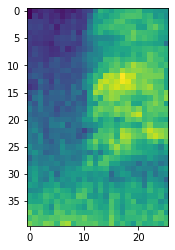

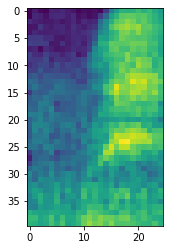

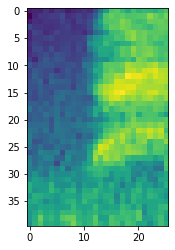

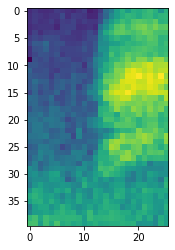

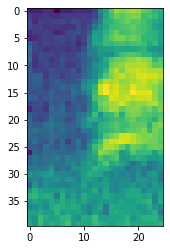

In [62]:
audio_segments, times, sample_rate = explore.get_first_audio_events(wav_path, annotation_df, event_class='Q', event_category='POS', n=n_events, expand=0.0)
transform_mel = lambda x: sed_utils.wav_to_mel(x - (np.sum(x)/np.size(x)), sample_rate)
for audio_segment in audio_segments:
    S = transform_mel(audio_segment)
    plt.imshow(np.flip(S, axis=0))
    plt.show()


In [41]:
wav_path = os.path.join(root_path, 'HT/a1.wav')
csv_path = os.path.join(root_path, 'HT/a1.csv')

wav, sr = librosa.load(wav_path, sr=None)
total_duration = len(wav)/sr

(128, 5625)
(5, 5625)


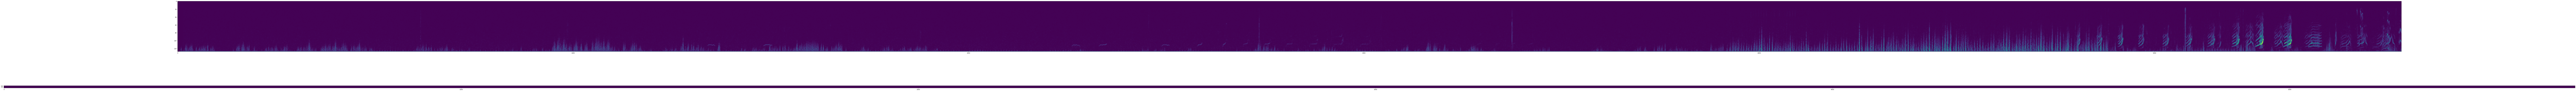

In [28]:
n_fft = 2048
hop_length = 512
center = True # D[t] -> y[t * hop_length]

D = librosa.feature.melspectrogram(
    wav, 
    sr=sr,
    
)

S = librosa.core.pcen(
    D, 
    sr=sr,
    gain=0.8,
    bias=10,
    power=0.25,
    time_constant=0.06,
    eps=1e-6
)

N = S.shape[1]//10

x = np.ones((5, N))

S = S[:,:N]

print(S.shape)
print(x.shape)

fig, ax = plt.subplots(2, 1, figsize=(total_duration/10, 16))
ax[0].imshow(np.flip(S, axis=0))
ax[1].imshow(x)

In [27]:
%matplotlib inline
from scipy.signal import spectrogram
import holoviews as hv 
import panel as pn
import os
import numpy as np
import librosa
import explore
import pandas as pd
from scipy.io import wavfile
hv.extension("bokeh", logo=False)

wav_path = os.path.join(root_path, 'HT/a1.wav')
csv_path = os.path.join(root_path, 'HT/a1.csv')
annotation_df = pd.read_csv(csv_path)

audio_data, sr = librosa.load(wav_path, sr=None)

audio_data, times, sample_rate = explore.get_first_audio_events_consecutive_audio(wav_path, annotation_df, event_class='WHP', event_category='POS', n=5, expand=0.0)
audio_data = (audio_data*(2**15)).astype(np.int16)


#sr, audio_data = wavfile.read(wav_path)
#audio_data = audio_data[:60*sr]

f, t, sxx = spectrogram(audio_data, sr)
spec_gram = hv.Image((t, f, np.log10(sxx)), ["Time (s)", "Frequency (hz)"]).opts(width=600)
audio = pn.pane.Audio(audio_data, sample_rate=sr, name='Audio', throttle=500)

def update_playhead(x,y,t):
    if x is None:
        return hv.VLine(t)
    else:
        audio.time = x
        return hv.VLine(x)

tap_stream = hv.streams.SingleTap(transient=True)
time_play_stream = hv.streams.Params(parameters=[audio.param.time], rename={'time': 't'})
dmap_time = hv.DynamicMap(update_playhead, streams=[time_play_stream, tap_stream])
out = pn.Column( audio, 
               (spec_gram * dmap_time))
out

Column
    [0] Audio(ndarray, sample_rate=8000, throttle=500)
    [1] HoloViews(DynamicMap)